# Kalman Filter Multivariado 
Este archivo esta basado en lo siguiente: 
https://www.quantopian.com/posts/pairs-trading-with-machine-learning

In [1]:
!pip install pykalman
!pip install johansen 
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing


In [3]:

from pykalman import KalmanFilter
import statsmodels.api as sm

## Importar base de datos

In [4]:
base=pd.read_excel("base_kalman_multivariado.xlsx",index_col=0).bfill()#.resample("w").last()

In [5]:
base.columns

Index(['S&P 500 INDEX', 'ISHARES MSCI EAFE ETF', 'BRAZIL IBOVESPA INDEX',
       'S&P/CLX IPSA (CLP) TR', 'S&P/BMV IPC', 'COLOMBIA COLCAP INDEX',
       'SPX 500 vs ROW', 'SPX  vs COL', 'COLOM CDS USD SR 5Y D14 Corp',
       'BRAZIL CDS USD SR 5Y D14 Corp', 'CHILE CDS USD SR 5Y D14 Corp',
       'MEX CDS USD SR 5Y D14 Corp', 'CL1 Comdty', 'SCO1 Comdty',
       'LMCADS03 Comdty', 'US 10Y Bond', 'UK 10Y Bond', 'COP 10Y Bond',
       'MEX 10Y Bond', 'BRL 10Y Bond', 'CHL 10Y Bond', 'US 10Y- COL 10Y',
       'USD/BRL', 'USD/COP', 'USD/CLP', 'USD/MXN', 'EUR/USD', 'GBP/USD',
       'DXY'],
      dtype='object')

In [6]:
base.head()

,S&P 500 INDEX,ISHARES MSCI EAFE ETF,BRAZIL IBOVESPA INDEX,S&P/CLX IPSA (CLP) TR,S&P/BMV IPC,COLOMBIA COLCAP INDEX,SPX 500 vs ROW,SPX vs COL,COLOM CDS USD SR 5Y D14 Corp,BRAZIL CDS USD SR 5Y D14 Corp,...,BRL 10Y Bond,CHL 10Y Bond,US 10Y- COL 10Y,USD/BRL,USD/COP,USD/CLP,USD/MXN,EUR/USD,GBP/USD,DXY
Dates,,,,,,,,,,,,,,,,,,,,,
2012-11-19,1386.89,42.7399,56450.9,4191.12,40830.60,1743.83,32.449538,0.795313,101.750,104.625,...,9.441,5.437,4.4699,2.0823,1818.5,480.08,13.0579,1.2814,1.5909,80.874
2012-11-20,1387.81,42.8081,56450.9,4179.70,41184.00,1743.33,32.419332,0.796068,100.000,103.813,...,9.447,5.459,4.4021,2.0806,1816.0,478.11,13.0044,1.2817,1.5927,80.957
2012-11-21,1391.03,42.8804,56242.1,4145.42,41668.06,1748.26,32.439763,0.795665,101.333,104.667,...,9.509,5.493,4.3754,2.0985,1815.7,477.95,13.0600,1.2829,1.5952,80.932
2012-11-22,1391.03,42.8804,56437.0,4139.68,42032.35,1746.00,32.439763,0.796695,100.838,104.503,...,9.515,5.539,4.3784,2.1045,1815.7,476.85,13.0298,1.2884,1.5937,80.699
2012-11-23,1409.15,43.8040,57574.0,4143.25,41919.55,1743.39,32.169437,0.808282,100.169,103.846,...,9.455,5.573,4.3071,2.0815,1823.5,478.77,12.9647,1.2976,1.6028,80.192


In [7]:
base[base.columns[:15]].columns

Index(['S&P 500 INDEX', 'ISHARES MSCI EAFE ETF', 'BRAZIL IBOVESPA INDEX',
       'S&P/CLX IPSA (CLP) TR', 'S&P/BMV IPC', 'COLOMBIA COLCAP INDEX',
       'SPX 500 vs ROW', 'SPX  vs COL', 'COLOM CDS USD SR 5Y D14 Corp',
       'BRAZIL CDS USD SR 5Y D14 Corp', 'CHILE CDS USD SR 5Y D14 Corp',
       'MEX CDS USD SR 5Y D14 Corp', 'CL1 Comdty', 'SCO1 Comdty',
       'LMCADS03 Comdty'],
      dtype='object')

In [8]:
base[base.columns[15:23]].columns

Index(['US 10Y Bond', 'UK 10Y Bond', 'COP 10Y Bond', 'MEX 10Y Bond',
       'BRL 10Y Bond', 'CHL 10Y Bond', 'US 10Y- COL 10Y', 'USD/BRL'],
      dtype='object')

In [9]:
base[base.columns[23:]].columns

Index(['USD/COP', 'USD/CLP', 'USD/MXN', 'EUR/USD', 'GBP/USD', 'DXY'], dtype='object')

### Crear retornos

In [10]:
#--------------------------------------------- crear retornos de la base -------------------------------------
# Dado que la base contiene negativos o valores cercanos a ceros por los bonos en este caso solo lo voy a hacer con
# los retornos compuestos, no logarítmicos 
retorno=pd.DataFrame(np.log(base[base.columns[:15]])-np.log(base[base.columns[:15]].shift(1))).fillna(0)*100
retorno=retorno.join(pd.DataFrame(base[base.columns[15:23]]-base[base.columns[15:23]].shift(1)))
retorno=retorno.join((np.log(base[base.columns[23:]])-np.log(base[base.columns[23:]].shift(1)))*100)
retorno=retorno.dropna()
#retorno['USD/MXN']=-retorno['USD/MXN']

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [11]:
retorno.head()

,S&P 500 INDEX,ISHARES MSCI EAFE ETF,BRAZIL IBOVESPA INDEX,S&P/CLX IPSA (CLP) TR,S&P/BMV IPC,COLOMBIA COLCAP INDEX,SPX 500 vs ROW,SPX vs COL,COLOM CDS USD SR 5Y D14 Corp,BRAZIL CDS USD SR 5Y D14 Corp,...,BRL 10Y Bond,CHL 10Y Bond,US 10Y- COL 10Y,USD/BRL,USD/COP,USD/CLP,USD/MXN,EUR/USD,GBP/USD,DXY
Dates,,,,,,,,,,,,,,,,,,,,,
2012-11-20,0.066313,0.159443,0.000000,-0.272853,0.861803,-0.028677,-0.093129,0.094990,-1.734864,-0.779133,...,0.006,0.022,-0.0678,-0.0017,-0.137571,-0.411193,-0.410555,0.023409,0.113080,0.102576
2012-11-21,0.231751,0.168751,-0.370565,-0.823536,1.168506,0.282393,0.063001,-0.050642,1.324194,0.819268,...,0.062,0.034,-0.0267,0.0179,-0.016521,-0.033471,0.426636,0.093582,0.156843,-0.030885
2012-11-22,0.000000,0.000000,0.345939,-0.138562,0.870467,-0.129355,0.000000,0.129355,-0.489685,-0.156810,...,0.006,0.046,0.0030,0.0060,0.000000,-0.230415,-0.231508,0.427800,-0.094076,-0.288311
2012-11-23,1.294221,2.131029,1.994611,0.086201,-0.268725,-0.149596,-0.836809,1.443817,-0.665651,-0.630675,...,-0.060,0.034,-0.0713,-0.0230,0.428666,0.401834,-0.500876,0.711527,0.569374,-0.630242
2012-11-26,-0.203165,-0.238619,-1.464276,-0.253746,-0.098523,-0.478950,0.035453,0.275784,1.809445,1.734575,...,-0.039,-0.018,-0.0366,-0.0001,0.016451,0.593511,0.394909,-0.030831,-0.006239,0.073546


In [12]:
retorno.shape

(1846, 29)

### PCA - para ver pares similares

Para indentificar que activos se pueden parecer más al peso colombiano voy a utilizar PCA. Con el objetivo de descomponer los componentes principales de los retornos y ver que factores se asemejan entre los principales activos

In [13]:
#12
N_PRIN_COMPONENTS = 12
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(retorno)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by the first 2 PCs'.format(percentage_cum[-1]*100))


96.40% of the variance is explained by the first 2 PCs


In [14]:
pca.components_[:].shape

(12, 29)

In [15]:
X=pca.components_[:].T
print(X.shape)

(29, 12)


In [16]:
# ---------------------- arreglar los datos escalandolos con el caso estandar -------------------------
X = preprocessing.StandardScaler().fit_transform(X) # Z=(x-u)/sigma
print (X.shape)

(29, 12)


### USar algorirmo de clustering DBSCA

In [17]:
clf = DBSCAN(eps=1.9, min_samples=2)
print (clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)

clustered = (clf.labels_)

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

Clusters discovered: 4


In [18]:
labels

array([-1, -1, -1,  0,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,
        2,  2,  2,  2,  2,  2,  1,  1,  1,  3,  3,  1], dtype=int64)

In [19]:
clustered_series = pd.Series(index=retorno.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=retorno.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [20]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

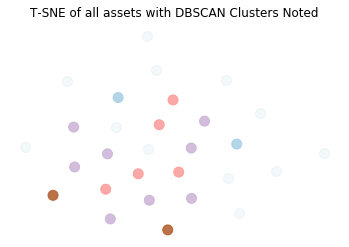

In [21]:
import matplotlib.cm as cm
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all assets with DBSCAN Clusters Noted');

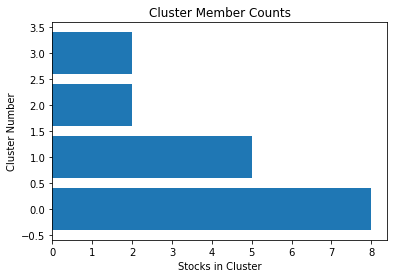

In [22]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

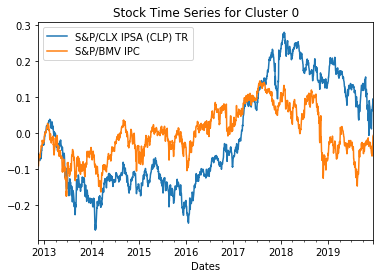

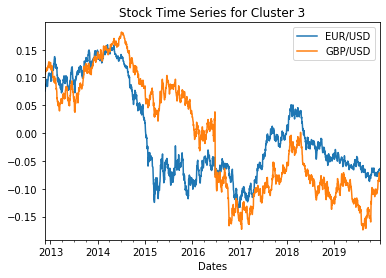

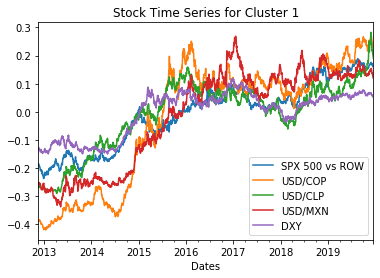

In [23]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(base[tickers].mean())
    data = np.log(base[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

Ahora voy a identificar de que cluster es el USD/COP

In [24]:
which_cluster = clustered_series.loc["USD/COP"]
clustered_series[clustered_series == which_cluster]

SPX 500 vs ROW    1
USD/COP           1
USD/CLP           1
USD/MXN           1
DXY               1
dtype: int64

Gráfico para el cluster

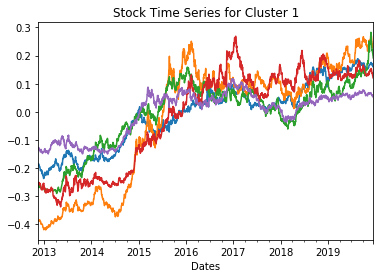

In [25]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(base[tickers].mean())
data = np.log(base[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

# Prueba de cointegración

In [27]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [28]:
for i, which_clust in enumerate(ticker_count_reduced.index):
    print (which_clust)

NameError: name 'ticker_count_reduced' is not defined

In [ ]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        np.log(base[tickers])
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [ ]:
cluster_dict

In [ ]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [ ]:
pairs

#### Ejercicio para tres activos
voy a intentar explicar el USD/COP con el CLP y BRL.

In [ ]:
if __name__ == "__main__":
    file_name = 'KalmanExample.txt'
    #df = pd.read_csv(file_name, index_col = 0)
    prices = base[['USD/COP', 'USD/CLP', 'USD/BRL']]
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(3)
    obs_mat = np.vstack( [prices['USD/CLP'], prices['USD/BRL'],  
                          np.ones(prices['USD/CLP'].shape)]).T[:, np.newaxis]
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=3,
        initial_state_mean=np.zeros(3),
        initial_state_covariance=np.ones((3, 3)),
        transition_matrices=np.eye(3),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov        
    )

    # state_means, state_covs = kf.em(prices['ETF'].values).smooth(prices['ETF'].values)
    state_means, state_covs = kf.filter(prices['USD/COP'].values)


    # Re-construct ETF from coefficients and 'ASSET_1' and ASSET_2 values:
    ETF_est = np.array([a.dot(b) for a, b in zip(np.squeeze(obs_mat), state_means)])

    # Draw slope and intercept...
    pd.DataFrame(
        dict(
            slope1=state_means[:, 0],
            slope2=state_means[:, 1],
            intercept=state_means[:, 2],
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

    # Draw actual y, and estimated y:
    datos_prediccion=pd.DataFrame(
        dict(
            ETF_est=ETF_est,
            ETF_act=prices['USD/COP'].values
        ), index=prices.index
    )
    datos_prediccion.plot()
    plt.show()

In [ ]:
datos_prediccion[-300:].plot()

### Para multiples activos y sus rezagos
Voy a hacer dos ejercicio uno con los datos en el momento t y otro con los datos en t-1. Primero voy a hacerlo en el momento t.

#### Momento t
Creo una base de datos que contenga los activos a analizar. Debe dejar el USD/COP de primera y luego agregar los otros activos que quiera usar

In [26]:
activos=clustered_series[clustered_series == which_cluster].index.drop("USD/COP")

In [35]:
df_1=base[activos].shift(0)
df_2=base[activos].shift(1)
df=pd.DataFrame(base['USD/COP'])
df=df.join(df_2).bfill()

df["rezago"]=base["USD/COP"].shift(1)

In [36]:
df.head()

,USD/COP,SPX 500 vs ROW,USD/CLP,USD/MXN,DXY,rezago
Dates,,,,,,
2012-11-19,1818.5,32.449538,480.08,13.0579,80.874,NaN
2012-11-20,1816.0,32.449538,480.08,13.0579,80.874,1818.5
2012-11-21,1815.7,32.419332,478.11,13.0044,80.957,1816.0
2012-11-22,1815.7,32.439763,477.95,13.0600,80.932,1815.7
2012-11-23,1823.5,32.439763,476.85,13.0298,80.699,1815.7


In [37]:
base[activos].head()

,SPX 500 vs ROW,USD/CLP,USD/MXN,DXY
Dates,,,,
2012-11-19,32.449538,480.08,13.0579,80.874
2012-11-20,32.419332,478.11,13.0044,80.957
2012-11-21,32.439763,477.95,13.0600,80.932
2012-11-22,32.439763,476.85,13.0298,80.699
2012-11-23,32.169437,478.77,12.9647,80.192


In [38]:
def filtro_de_kalman(df):########################## Parámetros ##########################
    numero_activos=len(df.columns)
    prices = df.bfill()
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(numero_activos)

    ########################## Matriz de observaciones #################
    # Empiezo en 1 porque 0 es el USD/COP
    obs_mat=prices[prices.columns[1]]
    for i in range(2,len(prices.columns)):
        obs_mat=np.vstack([obs_mat,prices[prices.columns[i]]])
    obs_mat=np.vstack([obs_mat,np.ones(prices[prices.columns[1]].shape)]).T[:, np.newaxis]

    #obs_mat = np.vstack( [prices['USD/BRL'],prices['USD/CLP'],prices['USD/MXN'], prices["DXY"],prices['COLOM CDS USD SR 5Y D14 Corp'],
    #                      prices['CL1 Comdty'],
    #                          np.ones(prices['USD/CLP'].shape)]).T[:, np.newaxis]

    ##################### Modelo del Filtro de kalman ####################
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=numero_activos,
        initial_state_mean=np.zeros(numero_activos),
        initial_state_covariance=np.ones((numero_activos, numero_activos)),
        transition_matrices=np.eye(numero_activos),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov        
        )

        # state_means, state_covs = kf.em(prices['ETF'].values).smooth(prices['ETF'].values)
    state_means, state_covs = kf.filter(prices[prices.columns[0]].values)

    ################## Crear data frame de los betas ####################
    dict_1={}
    for i in range(0,len(prices.columns)-1):
        dict_1[prices.columns[i+1]]=state_means[:, i]
    dict_1["intercept"]=state_means[:,len(prices.columns)-1]
    datos_betas=pd.DataFrame(dict_1,index=prices.index)
    
    #datos_betas=pd.DataFrame(
#    dict(
#        #beta_rezago=state_means[:, 0],
#        beta_real=state_means[:, 0],
#        beta_clp=state_means[:, 1],
#        beta_mxn=state_means[:, 2],
#        beta_dxy=state_means[:, 3],
#        beta_cds=state_means[:, 4],
#        beta_cl1=state_means[:, 5],
#        intercept=state_means[:, 6],
#        ), index=prices.index
#    )
    return datos_betas

In [39]:
len(base)

1847

In [41]:
prueba=1400
betas_out=pd.DataFrame()
for i in range(0,prueba+1):
    df_betas=(df[:len(df)-prueba+i])
    betas_out=betas_out.append(filtro_de_kalman(df_betas)[-1:],sort=True)

In [42]:
len(betas_out)

1401

In [43]:
betas_out

,DXY,SPX 500 vs ROW,USD/CLP,USD/MXN,intercept,rezago
Dates,,,,,,
2014-08-05,0.794914,0.765192,0.775046,0.754647,0.750248,0.716559
2014-08-06,0.795599,0.765246,0.768194,0.754548,0.750257,0.708457
2014-08-07,0.795907,0.765394,0.770005,0.754557,0.750260,0.710407
2014-08-08,0.796009,0.765459,0.770485,0.754586,0.750261,0.712059
2014-08-11,0.796082,0.765223,0.771239,0.754607,0.750260,0.706954
...,...,...,...,...,...,...
2019-12-11,2.221919,1.399526,2.856197,0.955109,0.766965,0.249712
2019-12-12,2.225089,1.401274,2.854203,0.955381,0.767014,0.259272
2019-12-13,2.226101,1.401563,2.855329,0.955306,0.767016,0.263089


In [44]:
betas_out.tail(1).sort_values(by=betas_out.index[len(betas_out)-1],axis=1,ascending=False)
orden=betas_out.tail(1).sort_values(by=betas_out.index[len(betas_out)-1],axis=1,ascending=False).columns

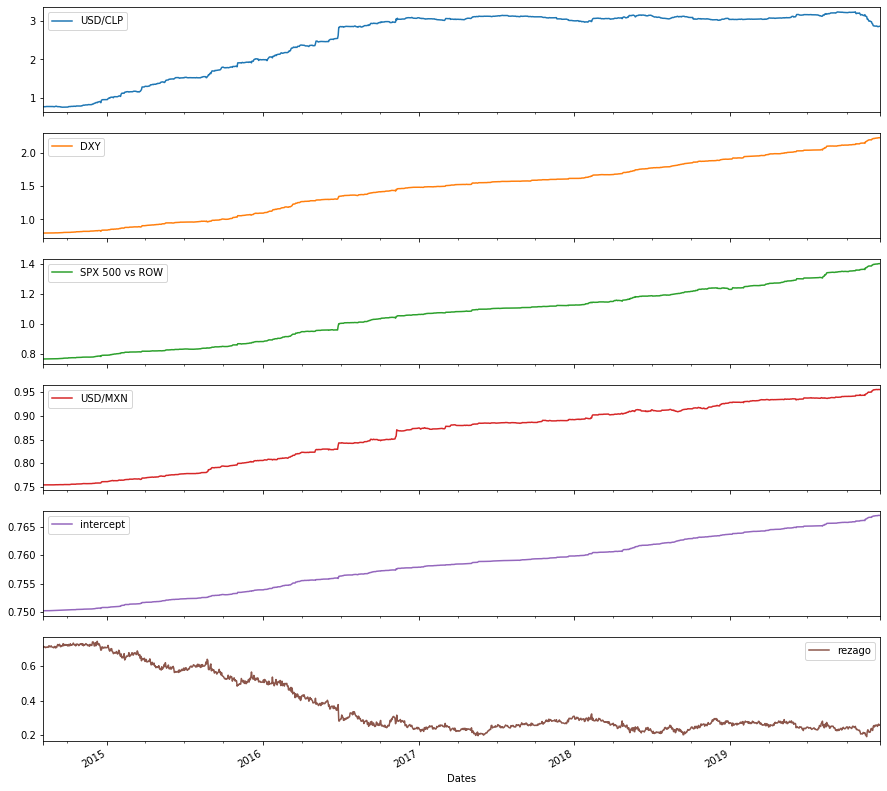

In [45]:
betas_out[orden].plot(subplots=True,figsize=(15,15))
plt.show()

# Prueba

In [46]:
# Betas normal
betas_out.tail()

,DXY,SPX 500 vs ROW,USD/CLP,USD/MXN,intercept,rezago
Dates,,,,,,
2019-12-11,2.221919,1.399526,2.856197,0.955109,0.766965,0.249712
2019-12-12,2.225089,1.401274,2.854203,0.955381,0.767014,0.259272
2019-12-13,2.226101,1.401563,2.855329,0.955306,0.767016,0.263089
2019-12-16,2.226344,1.402155,2.862363,0.955311,0.767011,0.256579
2019-12-17,2.226459,1.402194,2.862955,0.955319,0.767013,0.256951


In [49]:
# Betas rezagados un periodo 
betas=betas_out.shift().ffill()
betas.columns

Index(['DXY', 'SPX 500 vs ROW', 'USD/CLP', 'USD/MXN', 'intercept', 'rezago'], dtype='object')

In [52]:
betas=betas[['DXY', 'SPX 500 vs ROW', 'USD/CLP', 'USD/MXN', 'rezago','intercept']]

In [53]:
precios_prueba=pd.DataFrame(df[betas.columns[:-1]])[betas_out.index[0]:]

precios_prueba["intercepto"]=1
precios_prueba.tail()

,DXY,SPX 500 vs ROW,USD/CLP,USD/MXN,rezago,intercepto
Dates,,,,,,
2019-12-11,97.413,46.339944,778.79,19.2564,3405.0,1
2019-12-12,97.078,46.231239,769.78,19.1176,3375.1,1
2019-12-13,97.452,46.317690,769.45,19.0597,3372.0,1
2019-12-16,97.171,46.001841,763.63,19.0407,3385.0,1
2019-12-17,96.965,45.840994,761.71,18.9323,3354.1,1


In [54]:
base['USD/COP'][:].tail()

Dates
2019-12-11    3375.1
2019-12-12    3372.0
2019-12-13    3385.0
2019-12-16    3354.1
2019-12-17    3341.6
Name: USD/COP, dtype: float64

In [55]:
pronostico=pd.DataFrame(np.multiply(np.array(precios_prueba), np.array(betas)).sum(axis=1), index=precios_prueba.index,columns=["pronostico"])
pronostico.tail()

,pronostico
Dates,
2019-12-11,3410.279434
2019-12-12,3340.873107
2019-12-13,3371.149788
2019-12-16,3370.714614
2019-12-17,3339.889621


In [64]:
pronostico[-300:].shift(-1).tail()

,pronostico
Dates,
2019-12-11,3340.873107
2019-12-12,3371.149788
2019-12-13,3370.714614
2019-12-16,3339.889621
2019-12-17,NaN


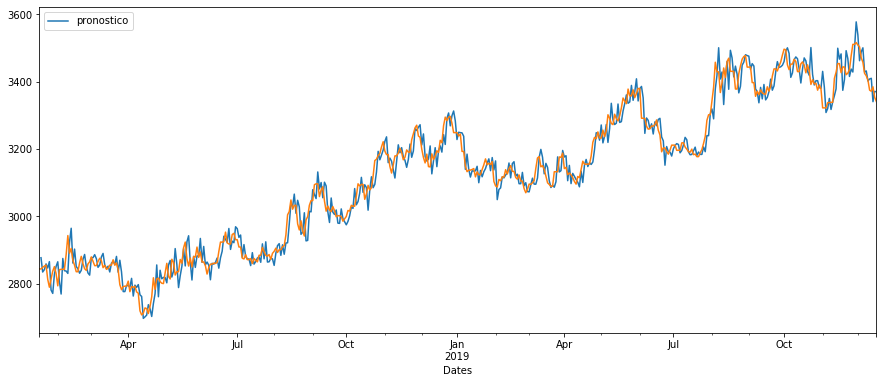

In [63]:
grph=pronostico[-500:]
(grph.shift()).plot(figsize=(15,6))
base['USD/COP'][-len(grph):].plot(figsize=(15,6))
plt.show()


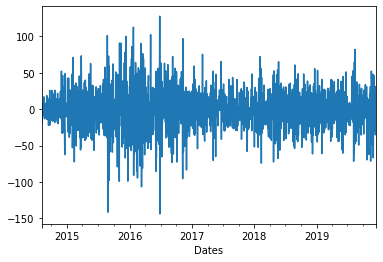

In [61]:
(base['USD/COP'][-len(pronostico):]-pronostico[pronostico.columns[0]]).plot()

# Backtest

In [80]:
base_pronostico=pronostico.shift(-1)
base_datos_reales=base['USD/COP'][-len(pronostico):]

r_p=base_pronostico.join(base_datos_reales)
r_p["fcst"]=(r_p["pronostico"]/r_p["USD/COP"]-1)*100
r_p["long"]=np.where(r_p["fcst"]>0,1,0)
r_p["short"]=np.where(r_p["fcst"]<0,-1,0)
r_p["accion"]=r_p["long"].shift(1)+r_p["short"].shift(1)

In [81]:
r_p.dropna()

,pronostico,USD/COP,fcst,long,short,accion
Dates,,,,,,
2014-08-06,1881.643612,1886.36,-0.250026,0,-1,1.0
2014-08-07,1886.545042,1886.40,0.007689,1,0,-1.0
2014-08-08,1891.469611,1889.95,0.080405,1,0,1.0
2014-08-11,1875.833288,1882.25,-0.340906,0,-1,1.0
2014-08-12,1872.694116,1876.00,-0.176220,0,-1,-1.0
...,...,...,...,...,...,...
2019-12-10,3410.279434,3405.00,0.155049,1,0,-1.0
2019-12-11,3340.873107,3375.10,-1.014100,0,-1,1.0
2019-12-12,3371.149788,3372.00,-0.025214,0,-1,-1.0


In [101]:
r_cop=base_datos_reales=pd.DataFrame(np.log(base['USD/COP'])-np.log(base['USD/COP'].shift(1)))*100
r_cop["posicion"]=r_p["accion"]
r_cop["price"]=base["USD/COP"]
r_cop=r_cop.dropna()
r_cop
r_e=pd.DataFrame(r_cop["USD/COP"]*r_cop["posicion"])
r_e["cum"]=r_e[r_e.columns[0]].cumsum()

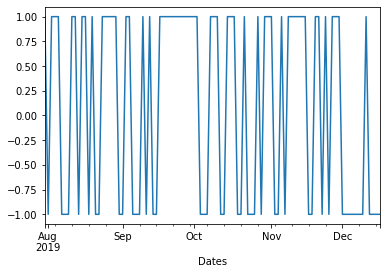

In [109]:
r_cop['posicion'][-100:].plot()

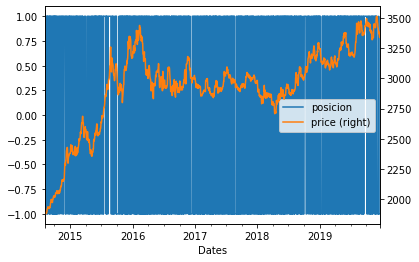

In [105]:
r_cop[r_cop.columns[-2:]].plot(secondary_y=[r_cop.columns[-1:]])
plt.show()

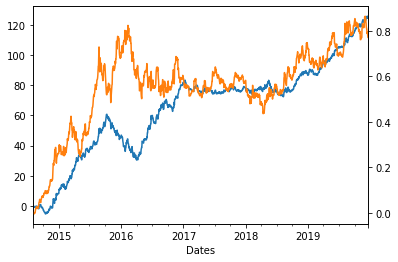

In [115]:
r_e["cum"].plot()
((r_cop["price"]/r_cop["price"].iloc[1])-1).plot(secondary_y="price")

# Johansen test

In [38]:
'''
function result = johansen(x,p,k)
% PURPOSE: perform Johansen cointegration tests
% -------------------------------------------------------
% USAGE: result = johansen(x,p,k)
% where:      x = input matrix of time-series in levels, (nobs x m)
%             p = order of time polynomial in the null-hypothesis
%                 p = -1, no deterministic part
%                 p =  0, for constant term
%                 p =  1, for constant plus time-trend
%                 p >  1, for higher order polynomial
%             k = number of lagged difference terms used when
%                 computing the estimator
% -------------------------------------------------------
% RETURNS: a results structure:
%          result.eig  = eigenvalues  (m x 1)
%          result.evec = eigenvectors (m x m), where first
%                        r columns are normalized coint vectors
%          result.lr1  = likelihood ratio trace statistic for r=0 to m-1
%                        (m x 1) vector
%          result.lr2  = maximum eigenvalue statistic for r=0 to m-1
%                        (m x 1) vector
%          result.cvt  = critical values for trace statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.cvm  = critical values for max eigen value statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.ind  = index of co-integrating variables ordered by
%                        size of the eigenvalues from large to small
% -------------------------------------------------------
% NOTE: c_sja(), c_sjt() provide critical values generated using
%       a method of MacKinnon (1994, 1996).
%       critical values are available for n<=12 and -1 <= p <= 1,
%       zeros are returned for other cases.
% -------------------------------------------------------
% SEE ALSO: prt_coint, a function that prints results
% -------------------------------------------------------
% References: Johansen (1988), 'Statistical Analysis of Co-integration
% vectors', Journal of Economic Dynamics and Control, 12, pp. 231-254.
% MacKinnon, Haug, Michelis (1996) 'Numerical distribution
% functions of likelihood ratio tests for cointegration',
% Queen's University Institute for Economic Research Discussion paper.
% (see also: MacKinnon's JBES 1994 article
% -------------------------------------------------------

% written by:
% James P. LeSage, Dept of Economics
% University of Toledo
% 2801 W. Bancroft St,
% Toledo, OH 43606
% jlesage@spatial-econometrics.com

% ****************************************************************
% NOTE: Adina Enache provided some bug fixes and corrections that
%       she notes below in comments. 4/10/2000
% ****************************************************************
'''

import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc